# Environment Setup

In [1]:
from google.colab import drive

drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/Comp4332'

Mounted at /content/drive


In [4]:
folder_path = '.'  # for local machine

In [1]:
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import sqrt
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt

# Using the SentenceTransformer library from Hugging Face for embeddings
from sentence_transformers import SentenceTransformer

# For loading environment variables
import os

c:\Users\keliv\anaconda3\envs\Comp4332\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Load Data

In [5]:
train_df = pd.read_csv(folder_path+"/data/review.csv")
val_df = pd.read_csv(folder_path+"/data/validation.csv")
test_df = pd.read_csv(folder_path+"/data/prediction.csv")

with open(folder_path+"/data/product.json", "r") as f:
    product_data = json.load(f)
product_df = pd.DataFrame(product_data)

In [6]:
unique_users = train_df["ReviewerID"].unique().tolist()
unique_items = train_df["ProductID"].unique().tolist()

c = 0
c_user_only = 0
c_item_only = 0
new_uers = []
new_items = []
for index, row in val_df.iterrows():
    if row["ProductID"] not in unique_items and row["ReviewerID"] not in unique_users:
        c += 1
        if row["ProductID"] not in new_items:
          new_items.append(row["ProductID"])
        if row["ReviewerID"] not in new_uers:
          new_uers.append(row["ReviewerID"])
        continue
    if row["ProductID"] not in unique_items:
        c_item_only += 1
        if row["ProductID"] not in new_items:
          new_items.append(row["ProductID"])
    if row["ReviewerID"] not in unique_users:
        c_user_only += 1
        if row["ReviewerID"] not in new_uers:
          new_uers.append(row["ReviewerID"])

print(f"Number of rows in validation set with both ProductID and ReviewerID not in training set: {c}")
print(f"Number of rows in validation set with only ProductID not in training set: {c_item_only}")
print(f"Number of rows in validation set with only ReviewerID not in training set: {c_user_only}")

print(f"length of new users: {len(new_uers)}")
print(f"length of new items: {len(new_items)}")

print(f'ratio: {len(new_items)/len(new_uers)}')

Number of rows in validation set with both ProductID and ReviewerID not in training set: 42
Number of rows in validation set with only ProductID not in training set: 1101
Number of rows in validation set with only ReviewerID not in training set: 359
length of new users: 47
length of new items: 302
ratio: 6.425531914893617


In [7]:
c = 0
c_user_only = 0
c_item_only = 0
new_uers = []
new_items = []
for index, row in test_df.iterrows():
    if row["ProductID"] not in unique_items and row["ReviewerID"] not in unique_users:
        c += 1
        if row["ProductID"] not in new_items:
          new_items.append(row["ProductID"])
        if row["ReviewerID"] not in new_uers:
          new_uers.append(row["ReviewerID"])
        continue
    if row["ProductID"] not in unique_items:
        c_item_only += 1
        if row["ProductID"] not in new_items:
          new_items.append(row["ProductID"])
    if row["ReviewerID"] not in unique_users:
        c_user_only += 1
        if row["ReviewerID"] not in new_uers:
          new_uers.append(row["ReviewerID"])

print(f"Number of rows in test set with both ProductID and ReviewerID not in training set: {c}")
print(f"Number of rows in test set with only ProductID not in training set: {c_item_only}")
print(f"Number of rows in test set with only ReviewerID not in training set: {c_user_only}")

print(f"length of new users: {len(new_uers)}")
print(f"length of new items: {len(new_items)}")
print(f'ratio: {len(new_items)/len(new_uers)}')

Number of rows in test set with both ProductID and ReviewerID not in training set: 34
Number of rows in test set with only ProductID not in training set: 1166
Number of rows in test set with only ReviewerID not in training set: 349
length of new users: 42
length of new items: 311
ratio: 7.404761904761905


# Data Preprocessing

## Create User Features

In [ ]:
unique_users = train_df["ReviewerID"].unique().tolist()
user_to_index = {u: i+1 for i, u in enumerate(unique_users)}  # reserve 0 for unknown
user_to_index["Unknown_User"] = 0

# text_model = SentenceTransformer('all-MiniLM-L6-v2')
text_model = SentenceTransformer('avsolatorio/GIST-small-Embedding-v0')
user_idx_to_embedding = {}

with torch.no_grad():
    for user_id, user_idx in user_to_index.items():
        if user_idx == 0:
            user_idx_to_embedding[user_idx] = text_model.encode("Unknown_User", convert_to_tensor=True)
            continue

        user_reviews = train_df[train_df["ReviewerID"] == user_id]["Text"].dropna().tolist()
        if len(user_reviews) == 0:
            user_idx_to_embedding[user_idx] = text_model.encode("Unknown_User", convert_to_tensor=True)
            continue
        combined_reviews = " ".join(user_reviews)
        user_idx_to_embedding[user_idx] = text_model.encode(combined_reviews, convert_to_tensor=True)

In [ ]:
dir_to_save = "./weights/mapping/avsolatorio/"
if not os.path.exists(dir_to_save):
    os.makedirs(dir_to_save)

path_to_save = os.path.join(dir_to_save, "user_idx_to_embedding_puretext.pth")

torch.save(user_idx_to_embedding, path_to_save)

## Create Product Feature

In [ ]:
# drop columns with all empty values
cols_to_drop = [col for col in product_df.columns
                if not product_df[col].astype(bool).any()]

# useless columns
cols_to_drop += ["price", "main_cat"]
product_df.drop(columns=cols_to_drop, inplace=True)

In [ ]:
unique_items = train_df["ProductID"].unique().tolist()
item_to_index = {p: i+1 for i, p in enumerate(unique_items)}
item_to_index["Unknown_Item"] = 0

# text_model = SentenceTransformer('all-MiniLM-L6-v2')
text_model = SentenceTransformer('avsolatorio/GIST-small-Embedding-v0')

item_idx_to_embedding = {}

with torch.no_grad():
    for item_id, item_idx in item_to_index.items():
        if item_idx == 0:
            item_idx_to_embedding[item_idx] = text_model.encode("Unknown_Item", convert_to_tensor=True)
            continue

        item_info = product_df[product_df["ProductID"] == item_id]
        item_info_json = item_info.to_json(orient='records')
        if len(item_info_json) == 0:
            item_idx_to_embedding[item_idx] = text_model.encode("Unknown_Item", convert_to_tensor=True)
            continue
        item_idx_to_embedding[item_idx] = text_model.encode(item_info_json, convert_to_tensor=True)

In [ ]:
dir_to_save = "./weights/mapping/avsolatorio/"
if not os.path.exists(dir_to_save):
    os.makedirs(dir_to_save)

path_to_save = os.path.join(dir_to_save, "item_idx_to_embedding_puretext.pth")
torch.save(user_idx_to_embedding, path_to_save)

## Encode IDs

In [8]:
# User and Product IDs
unique_users = train_df["ReviewerID"].unique().tolist()
unique_items = train_df["ProductID"].unique().tolist()
user_to_index = {u: i+1 for i, u in enumerate(unique_users)}  # reserve 0 for unknown
item_to_index = {p: i+1 for i, p in enumerate(unique_items)}
unknown_user_idx = 0
unknown_item_idx = 0

train_user_idx = train_df["ReviewerID"].apply(lambda x: user_to_index.get(x, unknown_user_idx)).values
train_item_idx = train_df["ProductID"].apply(lambda x: item_to_index.get(x, unknown_item_idx)).values
val_user_idx = val_df["ReviewerID"].apply(lambda x: user_to_index.get(x, unknown_user_idx)).values
val_item_idx = val_df["ProductID"].apply(lambda x: item_to_index.get(x, unknown_item_idx)).values
test_user_idx = test_df["ReviewerID"].apply(lambda x: user_to_index.get(x, unknown_user_idx)).values
test_item_idx = test_df["ProductID"].apply(lambda x: item_to_index.get(x, unknown_item_idx)).values

## Prepare Target Ratings

In [9]:
train_ratings = train_df["Star"].values.astype(np.float32)
val_ratings = val_df["Star"].values.astype(np.float32)

# Create a PyTorch Dataset

In [10]:
class RatingDataset(Dataset):
    def __init__(self, user_ids, item_ids, ratings):
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)
        self.item_ids = torch.tensor(item_ids, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return (self.user_ids[idx],
                self.item_ids[idx],
                self.ratings[idx])

In [11]:
train_dataset = RatingDataset(train_user_idx, train_item_idx, train_ratings)
val_dataset = RatingDataset(val_user_idx, val_item_idx, val_ratings)

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Define the Model in PyTorch

## 1st set of param

In [ ]:
# Training settings
model_name = "NeuralCF"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-2
lr_warmup_steps = 5
checkpoint_step = 5

embed_size = 384
num_layers_mlp = 4
dropout = 0.5
num_users = len(user_to_index) + 1 # +1 for unknown user
num_items = len(item_to_index) + 1 # +1 for unknown item
load_user_embed = False
load_item_embed = False
load_model = False

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super().__init__()
        self.fc_in = nn.Linear(input_size, hidden_size)
        self.mlp = nn.ModuleList()
        for i in range(2, num_layers):
            self.mlp.append(nn.Linear(hidden_size, hidden_size))
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.dropout = dropout

    def forward(self, x):
        x = F.layer_norm(x, x.size()[1:])
        x = self.fc_in(x)
        for layer in self.mlp:
            x = F.layer_norm(x, x.size()[1:])
            x = F.dropout(x, self.dropout, self.training)
            x = F.leaky_relu(x, 0.1)
            x = x + layer(x)
        x = F.layer_norm(x, x.size()[1:])
        x = F.dropout(x, self.dropout, self.training)
        x = F.leaky_relu(x, 0.1)
        x = self.fc_out(x)
        return x

In [ ]:
class RatingPredictor(nn.Module):
    def __init__(self, num_layers, dropout, user_emb_dim=embed_size, item_emb_dim=embed_size, hidden_dim=384):
        super(RatingPredictor, self).__init__()
        self.mlp = MLP(input_size=user_emb_dim + item_emb_dim, hidden_size=hidden_dim, output_size=1, num_layers=num_layers, dropout=dropout)

    def forward(self, user_ids, item_ids, user_emb, item_emb):
        # Get embeddings for user and item
        user_vec = user_emb(user_ids)       # (batch, user_emb_dim)
        item_vec = item_emb(item_ids)         # (batch, item_emb_dim)


        # Concatenate all features
        x = torch.cat([user_vec, item_vec], dim=1)
        x = self.mlp(x)
        # Use a scaled sigmoid so that outputs are between 1 and 5.
        out = 1 + 4 * torch.sigmoid(x)
        return out.squeeze(1)

## 2nd set of param

In [12]:
# Training settings
model_name = "NeuralCF_GMF_share_embed_bs_256_mk_005_03_flexible_lr"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50
learning_rate = 1e-3
weight_decay = 1e-5
lr_warmup_steps = 5
lr_fixed_steps = 20

embed_size = 384
num_layers_mlp = 4
dropout = 0.6
num_users = len(user_to_index) + 1 # +1 for unknown user
num_items = len(item_to_index) + 1 # +1 for unknown item
load_user_embed = False
load_item_embed = False
load_model = False

In [13]:
class GMF(nn.Module):
  def __init__(self, embed_dim):
      super().__init__()
      self.output_layer = nn.Linear(embed_dim, 1)

  def forward(self, user_emb, item_emb):
      # Element-wise product (GMF characteristic)
      gmf_vector = user_emb * item_emb
      return self.output_layer(gmf_vector)

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super().__init__()
        self.fc_in = nn.Linear(input_size, hidden_size)
        self.mlp = nn.ModuleList()
        for i in range(2, num_layers-1):
            self.mlp.append(nn.Linear(hidden_size, hidden_size))
        self.fc_hidden = nn.Linear(hidden_size, hidden_size//2)
        self.fc_out = nn.Linear(hidden_size//2, output_size)
        self.dropout = dropout

    def forward(self, x):
        x = F.layer_norm(x, x.size()[1:])
        x = self.fc_in(x)
        for layer in self.mlp:
            x = F.layer_norm(x, x.size()[1:])
            x = F.dropout(x, self.dropout, self.training)
            x = F.leaky_relu(x, 0.1)
            x = x + layer(x)
        x = F.layer_norm(x, x.size()[1:])
        x = F.dropout(x, self.dropout, self.training)
        x = self.fc_hidden(x)
        x = F.layer_norm(x, x.size()[1:])
        x = F.dropout(x, self.dropout, self.training)
        x = F.leaky_relu(x, 0.1)
        x = self.fc_out(x)
        return x

In [17]:
class RatingPredictor(nn.Module):
    def __init__(self, num_layers, dropout, user_emb_dim=embed_size, item_emb_dim=embed_size, hidden_dim=384):
        super(RatingPredictor, self).__init__()
        self.gmf = GMF(embed_dim=user_emb_dim)
        self.mlp = MLP(input_size=user_emb_dim + item_emb_dim, hidden_size=hidden_dim, output_size=1, num_layers=num_layers, dropout=dropout)
        self.combine = nn.Linear(2, 1)

    def forward(self, user_ids, item_ids, user_emb, item_emb):
        # Get embeddings for user and item
        user_vec = user_emb(user_ids)       # (batch, user_emb_dim)
        item_vec = item_emb(item_ids)         # (batch, item_emb_dim)

        gmf_out = self.gmf(user_vec, item_vec)

        mlp_input = torch.cat([user_vec, item_vec], dim=1)
        mlp_out = self.mlp(mlp_input)

        combined = torch.cat([gmf_out, mlp_out], dim=1)
        x = self.combine(combined)
        # Use a scaled sigmoid so that outputs are between 1 and 5.
        out = 1 + 4 * torch.sigmoid(x)
        return out.squeeze(1)

## 3rd set of param

In [ ]:
# Training settings
model_name = "NeuralCF_GMF_new_input"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50
learning_rate = 1e-3
weight_decay = 5e-2
lr_warmup_steps = 5
lr_fixed_steps = 20

embed_size = 384
num_layers_mlp = 4
dropout = 0.6
num_users = len(user_to_index) + 1 # +1 for unknown user
num_items = len(item_to_index) + 1 # +1 for unknown item
load_user_embed = False
load_item_embed = False
load_model = False

In [ ]:
class GMF(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    self.output_layer = nn.Linear(embed_dim, 1)

  def forward(self, user_emb, item_emb):
    x = user_emb * item_emb
    x = self.output_layer(x)
    return x

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
    super().__init__()

    self.fc_in = nn.Linear(input_size, hidden_size)
    self.mlp = nn.ModuleList()
    for i in range(2, num_layers-1):
        self.mlp.append(nn.Linear(hidden_size, hidden_size))
    self.fc_hidden = nn.Linear(hidden_size, hidden_size//2)
    self.fc_out = nn.Linear(hidden_size//2, output_size)
    self.dropout = dropout

  def forward(self, x):
    x = self.fc_in(x)
    x = F.layer_norm(x, x.size()[1:])
    x = F.leaky_relu(x, 0.1)
    x = F.dropout(x, self.dropout, self.training)
    # for layer in self.mlp:
    #     x = F.layer_norm(x, x.size()[1:])
    #     x = F.dropout(x, self.dropout, self.training)
    #     x = F.leaky_relu(x, 0.1)
    #     x = x + layer(x)
    x = self.fc_hidden(x)
    x = F.layer_norm(x, x.size()[1:])
    x = F.leaky_relu(x, 0.1)
    x = F.dropout(x, self.dropout, self.training)
    x = self.fc_out(x)
    x = F.layer_norm(x, x.size()[1:])
    x = F.leaky_relu(x, 0.1)
    x = F.dropout(x, self.dropout, self.training)
    return x

In [ ]:
class RatingPredictor(nn.Module):
    def __init__(self, num_layers, dropout, user_emb_dim=embed_size, item_emb_dim=embed_size, hidden_dim=384, num_users=num_users, num_items=num_items):
        super(RatingPredictor, self).__init__()
        self.gmf_user_embed = nn.Embedding(num_users, user_emb_dim//2)
        self.gmf_item_embed = nn.Embedding(num_items, item_emb_dim//2)

        self.gmf = GMF(embed_dim=user_emb_dim//2)
        self.mlp = MLP(input_size=user_emb_dim + item_emb_dim, hidden_size=hidden_dim, output_size=1, num_layers=num_layers, dropout=dropout)
        self.combine = nn.Linear(2, 1)

    def forward(self, user_ids, item_ids, user_emb, item_emb):
        # Get embeddings for user and item
        user_vec = user_emb(user_ids)       # (batch, user_emb_dim)
        item_vec = item_emb(item_ids)         # (batch, item_emb_dim)

        gmf_user_vec = self.gmf_user_embed(user_ids)       # (batch, user_emb_dim)
        gmf_item_vec = self.gmf_item_embed(item_ids)         # (batch, item_emb_dim)


        gmf_out = self.gmf(gmf_user_vec, gmf_item_vec)

        mlp_input = torch.cat([user_vec, item_vec], dim=1)
        mlp_out = self.mlp(mlp_input)

        combined = torch.cat([gmf_out, mlp_out], dim=1)
        x = self.combine(combined)
        # Use a scaled sigmoid so that outputs are between 1 and 5.
        out = 1 + 4 * torch.sigmoid(x)
        return out.squeeze(1)

## Set the Embedding Choice

In [24]:
user_idx_to_embedding = torch.load(folder_path+"/weights/mapping/user_idx_to_embedding_puretext.pth", weights_only=False)
item_idx_to_embedding = torch.load(folder_path+"/weights/mapping/item_idx_to_embedding_puretext.pth", weights_only=False)

user_embed = nn.Embedding(num_users, embed_size).to(device)
item_embed = nn.Embedding(num_items, embed_size).to(device)

if load_user_embed:
    user_embed.load_state_dict(torch.load(f"./weights/{model_name}/user_embedding.pth"))
else:
    user_embed = nn.Embedding.from_pretrained(torch.stack([user_idx_to_embedding[i] for i in range(num_users)], dim=0), freeze=False).to(device)

if load_item_embed:
    item_embed.load_state_dict(torch.load(f"./weights/{model_name}/item_embedding.pth"))
else:
    item_embed = nn.Embedding.from_pretrained(torch.stack([item_idx_to_embedding[i] for i in range(num_items)], dim=0), freeze=False).to(device)

In [23]:
model = RatingPredictor(num_layers=num_layers_mlp, dropout=dropout).to(device)

if load_model:
    model.load_state_dict(torch.load(f"./model/{model_name}.pth"))

In [69]:
model

RatingPredictor(
  (gmf): GMF(
    (output_layer): Linear(in_features=384, out_features=1, bias=True)
  )
  (mlp): MLP(
    (fc_in): Linear(in_features=768, out_features=384, bias=True)
    (mlp): ModuleList(
      (0): Linear(in_features=384, out_features=384, bias=True)
    )
    (fc_hidden): Linear(in_features=384, out_features=192, bias=True)
    (fc_out): Linear(in_features=192, out_features=1, bias=True)
  )
  (combine): Linear(in_features=2, out_features=1, bias=True)
)

# Training

## Training Setup

In [72]:
criterion = nn.MSELoss()
# optimizer = optim.AdamW(list(model.parameters()) + list(user_embed.parameters()) + list(item_embed.parameters()), lr=learning_rate, weight_decay=weight_decay)
optimizer = optim.AdamW([
    {'params': model.parameters(), 'lr': 1e-3},
    {'params': user_embed.parameters(), 'lr': 1e-4},  # Small LR for pretrained
    {'params': item_embed.parameters(), 'lr': 1e-4},
], weight_decay=weight_decay)

warmup_lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / lr_warmup_steps if epoch < lr_warmup_steps else 1)
fixed_lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 if lr_warmup_steps <= epoch < lr_fixed_steps else 0)
cosine_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(num_epochs - lr_fixed_steps), eta_min=1e-6)
lr_scheduler = optim.lr_scheduler.SequentialLR(optimizer, [warmup_lr_scheduler, fixed_lr_scheduler, cosine_lr_scheduler], milestones=[lr_warmup_steps, lr_fixed_steps])

In [ ]:
# fine-tuning
criterion = nn.MSELoss()
optimizer = optim.Adam(list(model.parameters()) + list(user_embed.parameters()) + list(item_embed.parameters()), lr=5e-4)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs-lr_warmup_steps, eta_min=1e-6)

In [73]:
def evaluate(model, loader, user_embed, item_embed):
    model.eval()
    user_embed.eval()
    item_embed.eval()
    losses = []
    preds = []
    trues = []
    with torch.no_grad():
        for batch in loader:
            user_ids, item_ids, ratings = batch
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            ratings = ratings.to(device)
            outputs = model(user_ids, item_ids, user_embed, item_embed)
            loss = criterion(outputs, ratings)
            losses.append(loss.item() * ratings.size(0))
            preds.extend(outputs.cpu().numpy())
            trues.extend(ratings.cpu().numpy())
    avg_loss = np.sum(losses) / len(loader.dataset)
    rmse_val = sqrt(np.mean((np.array(preds) - np.array(trues)) ** 2))
    return avg_loss, rmse_val

## Training Loop

In [21]:
user_embedding_weights = user_embed.weight

In [22]:
user_embedding_weights

Parameter containing:
tensor([[-0.0621,  0.0221, -0.0693,  ...,  0.0576, -0.0273,  0.0513],
        [-0.0623, -0.1073, -0.0259,  ..., -0.0003, -0.0250, -0.0100],
        [-0.0852, -0.0226,  0.0399,  ..., -0.0784, -0.0349, -0.0302],
        ...,
        [-0.0756, -0.0374, -0.0429,  ...,  0.0151,  0.0283,  0.0096],
        [-0.0520,  0.0311,  0.0653,  ...,  0.0721, -0.0608, -0.0167],
        [-0.0503, -0.0410, -0.0473,  ..., -0.0574, -0.0406,  0.0092]],
       requires_grad=True)

In [23]:
item_embedding_weights = item_embed.weight

In [24]:
item_embedding_weights

Parameter containing:
tensor([[-0.0731,  0.0738, -0.0421,  ..., -0.0147, -0.0724,  0.0643],
        [-0.0320,  0.0944, -0.0421,  ..., -0.0846,  0.0151,  0.0726],
        [-0.0462,  0.0775, -0.0293,  ..., -0.0815,  0.0285,  0.0520],
        ...,
        [-0.0232,  0.0735, -0.0400,  ..., -0.0605,  0.0312,  0.0710],
        [-0.0114,  0.0447, -0.0193,  ..., -0.0402,  0.0424,  0.0915],
        [-0.0113,  0.0849, -0.0261,  ..., -0.0802, -0.0044,  0.0739]],
       requires_grad=True)

In [20]:
train_losses = []
train_rmses = []
val_losses = []
val_rmses = []
lrs = []
best_val_loss = float('inf')
best_model_path = folder_path+"/model/" + model_name + ".pth"
best_user_embed_path = folder_path+"/model/" + model_name + "_user_embed" ".pth"
best_item_embed_path = folder_path+"/model/" + model_name + "_item_embed" ".pth"

In [74]:
# Early stopping parameters
patience = 5
epochs_no_improve = 0

def augment_batch(user_ids, item_ids, ratings):
  mask_user = torch.rand(user_ids.size()) < 0.05
  mask_item = torch.rand(item_ids.size()) < 0.3
  user_ids[mask_user] = 0  # "Unknown_User"
  item_ids[mask_item] = 0  # "Unknown_Item"
  return user_ids, item_ids, ratings


for epoch in range(num_epochs):
    model.train()
    user_embed.train()
    item_embed.train()

    running_loss = 0.0
    for batch in train_loader:
        user_ids, item_ids, ratings = batch
        user_ids, item_ids, ratings = augment_batch(user_ids, item_ids, ratings)
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        ratings = ratings.to(device)

        optimizer.zero_grad()
        outputs = model(user_ids, item_ids, user_embed, item_embed)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * ratings.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_rmse = evaluate(model, val_loader, user_embed, item_embed)
    train_losses.append(train_loss)
    train_rmses.append(sqrt(train_loss))
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    lrs.append(lr_scheduler.get_last_lr()[0])

    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {train_loss:.4f}  Train RMSE: {sqrt(train_loss):.4f}  Val Loss: {val_loss:.4f}  Val RMSE: {val_rmse:.4f}")

    # Save checkpoint if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        torch.save(user_embed.state_dict(), best_user_embed_path)
        torch.save(item_embed.state_dict(), best_item_embed_path)
        print(f'Checkpoint saved at epoch {epoch+1} with validation rmse {val_rmse:.4f}')
        epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve >= patience:
    #         print(f'Early stopping triggered after {patience} epochs without improvement.')
    #         break

Epoch 1/50 -- Train Loss: 3.5369  Train RMSE: 1.8807  Val Loss: 3.2495  Val RMSE: 1.8026
Checkpoint saved at epoch 1 with validation rmse 1.8026
Epoch 2/50 -- Train Loss: 1.0728  Train RMSE: 1.0358  Val Loss: 1.0340  Val RMSE: 1.0168
Checkpoint saved at epoch 2 with validation rmse 1.0168
Epoch 3/50 -- Train Loss: 0.9187  Train RMSE: 0.9585  Val Loss: 1.0439  Val RMSE: 1.0217
Epoch 4/50 -- Train Loss: 0.8982  Train RMSE: 0.9477  Val Loss: 0.8851  Val RMSE: 0.9408
Checkpoint saved at epoch 4 with validation rmse 0.9408
Epoch 5/50 -- Train Loss: 0.7169  Train RMSE: 0.8467  Val Loss: 0.7602  Val RMSE: 0.8719
Checkpoint saved at epoch 5 with validation rmse 0.8719
Epoch 6/50 -- Train Loss: 0.6134  Train RMSE: 0.7832  Val Loss: 0.7602  Val RMSE: 0.8719
Epoch 7/50 -- Train Loss: 0.6109  Train RMSE: 0.7816  Val Loss: 0.7602  Val RMSE: 0.8719
Epoch 8/50 -- Train Loss: 0.6148  Train RMSE: 0.7841  Val Loss: 0.7602  Val RMSE: 0.8719
Epoch 9/50 -- Train Loss: 0.6170  Train RMSE: 0.7855  Val Loss: 

KeyboardInterrupt: 

In [79]:
user_embedding_weights = user_embed.weight

In [80]:
user_embedding_weights

Parameter containing:
tensor([[-0.0630,  0.0228, -0.0679,  ...,  0.0562, -0.0281,  0.0510],
        [-0.0535, -0.0963, -0.0181,  ...,  0.0079, -0.0168, -0.0020],
        [-0.0895, -0.0279,  0.0378,  ..., -0.0793, -0.0385, -0.0357],
        ...,
        [-0.0777, -0.0416, -0.0467,  ...,  0.0102,  0.0246,  0.0045],
        [-0.0557,  0.0262,  0.0625,  ...,  0.0700, -0.0646, -0.0226],
        [-0.0514, -0.0433, -0.0501,  ..., -0.0597, -0.0435,  0.0073]],
       requires_grad=True)

In [81]:
item_embedding_weights = item_embed.weight

In [82]:
item_embedding_weights

Parameter containing:
tensor([[-0.0673,  0.0678, -0.0332,  ..., -0.0135, -0.0659,  0.0620],
        [-0.0388,  0.0976, -0.0459,  ..., -0.0894,  0.0104,  0.0749],
        [-0.0435,  0.0818, -0.0301,  ..., -0.0751,  0.0305,  0.0498],
        ...,
        [-0.0228,  0.0694, -0.0366,  ..., -0.0614,  0.0292,  0.0704],
        [-0.0152,  0.0441, -0.0169,  ..., -0.0435,  0.0404,  0.0948],
        [-0.0082,  0.0879, -0.0252,  ..., -0.0748, -0.0025,  0.0718]],
       requires_grad=True)

## Visualization

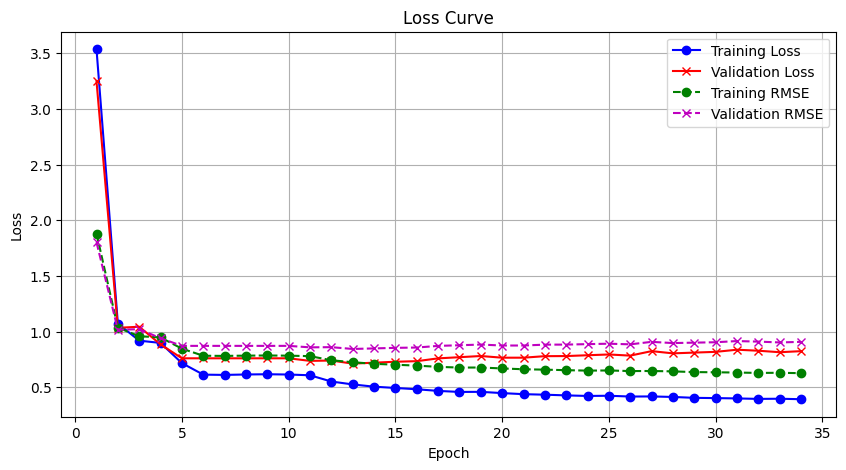

<Figure size 640x480 with 0 Axes>

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', linestyle='-', color='r', label='Validation Loss')
plt.plot(range(1, len(train_rmses) + 1), train_rmses, marker='o', linestyle='--', color='g', label='Training RMSE')
plt.plot(range(1, len(val_rmses) + 1), val_rmses, marker='x', linestyle='--', color='m', label='Validation RMSE')
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

if not os.path.exists(folder_path+"/picture/"):
    os.makedirs(folder_path+"/picture/")
plt.savefig(folder_path+"/picture/Loss_Curve_" + model_name + ".png")

# Generate Predictions

In [25]:
def generate_predictions(model, user_ids, item_ids, user_embed, item_embed):
    model.eval()
    user_embed.eval()
    item_embed.eval()
    inputs = {
        "user_ids": torch.tensor(user_ids, dtype=torch.long).to(device),
        "item_ids": torch.tensor(item_ids, dtype=torch.long).to(device),
    }
    with torch.no_grad():
        preds = model(inputs["user_ids"], inputs["item_ids"], user_embed, item_embed)
    return preds.cpu().numpy()

In [26]:
# load the best model
best_model = torch.load(best_model_path, weights_only=False)
model.load_state_dict(best_model)

best_user_embed = torch.load(best_user_embed_path, weights_only=False)
user_embed.load_state_dict(best_user_embed)

best_item_embed = torch.load(best_item_embed_path, weights_only=False)
item_embed.load_state_dict(best_item_embed)

<All keys matched successfully>

## Validation set

In [27]:
# Predictions for validation set
val_preds = generate_predictions(model, val_user_idx, val_item_idx, user_embed, item_embed)
# Compute RMSE manually (or use evaluate.py later)
val_rmse = sqrt(np.mean((val_preds - val_ratings) ** 2))
print(f"Final Validation RMSE: {val_rmse:.4f}")

Final Validation RMSE: 0.8441


In [28]:
# Save validation predictions to CSV (for evaluate.py)
val_pred_df = pd.DataFrame({
    "ReviewerID": val_df["ReviewerID"],
    "ProductID": val_df["ProductID"],
    "Star": val_preds
})

if not os.path.exists(folder_path + "/prediction/" + model_name + "/"):
    os.makedirs(folder_path + "/prediction/" + model_name + "/")

val_pred_df.to_csv(folder_path + "/prediction/" + model_name + "/validation_prediction.csv", index=False)

## Test set

In [29]:
# Predictions for test set
test_preds = generate_predictions(model, test_user_idx, test_item_idx, user_embed, item_embed)
test_pred_df = pd.DataFrame({
    "ReviewerID": test_df["ReviewerID"],
    "ProductID": test_df["ProductID"],
    "Star": test_preds
})

if not os.path.exists(folder_path + "/prediction/" + model_name + "/"):
    os.makedirs(folder_path + "/prediction/" + model_name + "/")
test_pred_df.to_csv(folder_path + "/prediction/" + model_name + "/prediction.csv", index=False)
print("Saved validation_prediction.csv and prediction.csv")

Saved validation_prediction.csv and prediction.csv
